In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
epsilons = np.arange(0, .5, 0.05)
pretrained_model = "data/lenet_mnist_model.pth"


In [3]:
use_cuda=torch.cuda.is_available()
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available:  True


In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
# Initialize the network
model = Classifier().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model.eval()

Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, gradient):

    sign_gradient = gradient.sign()
    transformed_image = image + epsilon*sign_gradient

    # Adding clipping to maintain [0,1] range
    transformed_image = torch.clamp(transformed_image, 0, 1)
    
    return transformed_image

In [11]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    n_correct = 0
    misclassified = []

    # Loop over all examples in test set
    for data, target in tqdm(test_loader):

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, grad)
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            n_correct += 1
            if (epsilon == 0) and (len(misclassified) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                misclassified.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(misclassified) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                misclassified.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    acc = n_correct/len(test_loader)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {n_correct} / {len(test_loader)} = {acc}")
    return acc, misclassified

In [12]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

100%|██████████| 10000/10000 [00:35<00:00, 284.36it/s]


Epsilon: 0.0	Test Accuracy = 9810 / 10000 = 0.981


100%|██████████| 10000/10000 [00:34<00:00, 291.20it/s]


Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426


100%|██████████| 10000/10000 [00:35<00:00, 283.78it/s]


Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851


100%|██████████| 10000/10000 [00:34<00:00, 293.02it/s]


Epsilon: 0.15000000000000002	Test Accuracy = 6826 / 10000 = 0.6826


100%|██████████| 10000/10000 [00:34<00:00, 289.45it/s]


Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301


100%|██████████| 10000/10000 [00:34<00:00, 288.17it/s]


Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082


100%|██████████| 10000/10000 [00:34<00:00, 289.76it/s]


Epsilon: 0.30000000000000004	Test Accuracy = 869 / 10000 = 0.0869


100%|██████████| 10000/10000 [00:34<00:00, 292.94it/s]


Epsilon: 0.35000000000000003	Test Accuracy = 352 / 10000 = 0.0352


100%|██████████| 10000/10000 [00:34<00:00, 289.19it/s]


Epsilon: 0.4	Test Accuracy = 167 / 10000 = 0.0167


100%|██████████| 10000/10000 [00:34<00:00, 291.21it/s]

Epsilon: 0.45	Test Accuracy = 85 / 10000 = 0.0085


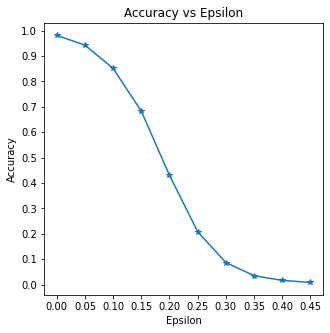

In [13]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, .5, 0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

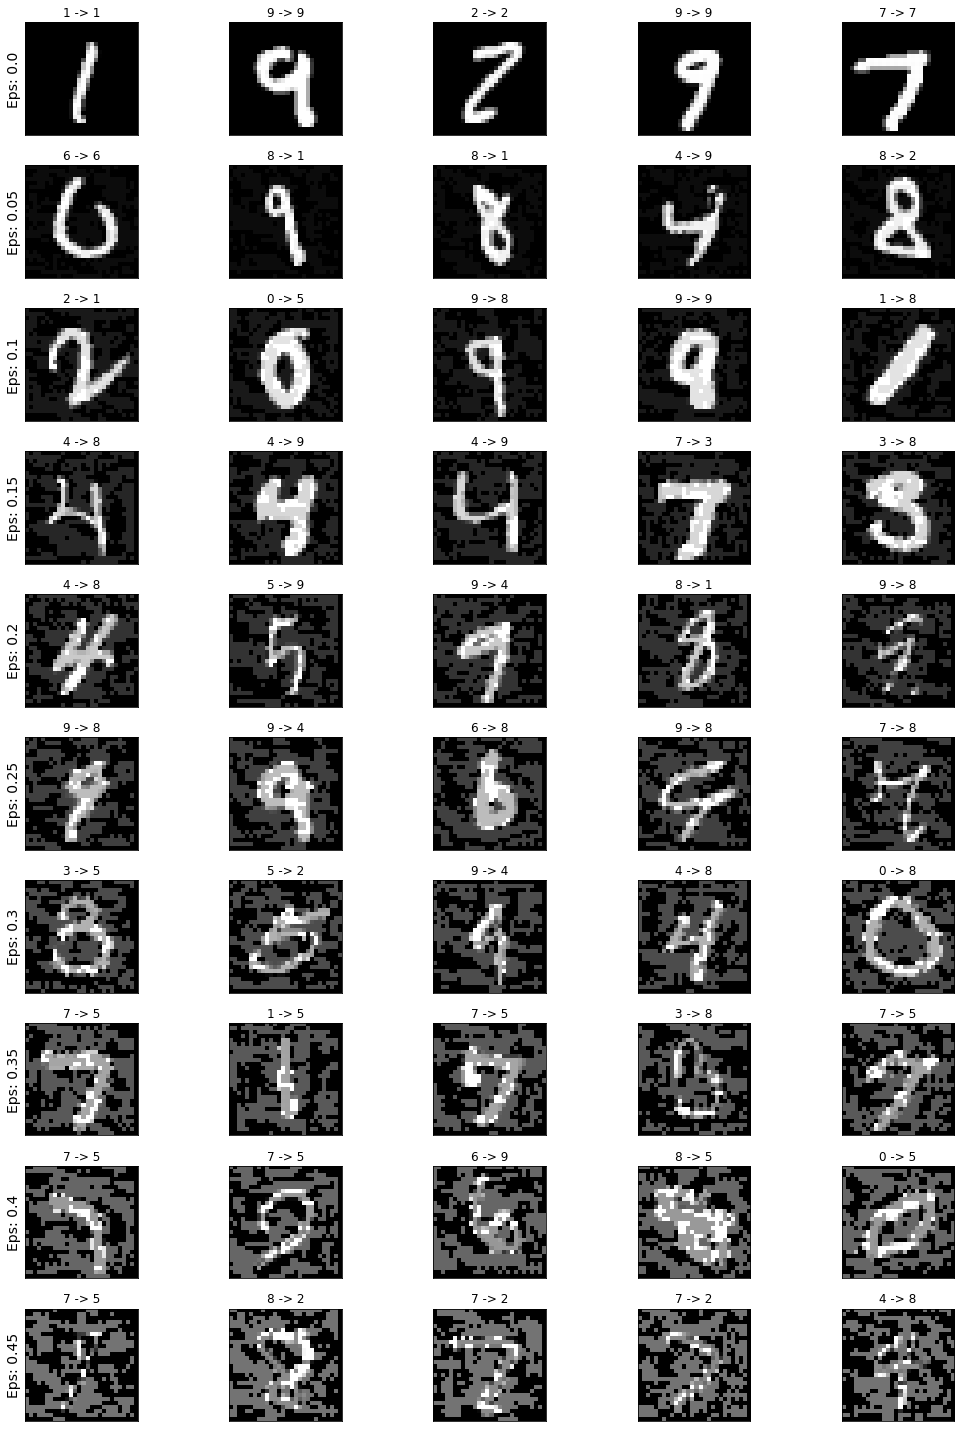

In [14]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(15,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {round(epsilons[i], 2)}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()